# Import boundary files
* City Boundary
* Council Districts, Neighborhood Councils, LA Times Neighborhoods
* Zipcodes, Census tracts, Congressional Districts
* Project to CA State Plane and also do spatial join with city boundary, keep only observations that intersect

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import intake
import os
import boto3

In [2]:
catalog = intake.open_catalog('../catalogs/*.yml')

In [3]:
s3 = boto3.client('s3')

In [4]:
# Open Data Catalog
city_boundary = catalog.city_boundary.read()
council_districts = catalog.council_districts.read()
neighborhoods = catalog.latimes_neighborhoods.read()
neighborhood_councils = catalog.neighborhood_councils.read()
zipcodes = catalog.zip_codes.read()

# Census TIGER shapefiles
tracts = gpd.read_file('../gis/Census/tl_2019_06_tract/')
congressional_districts = gpd.read_file('../gis/Census/tl_2019_us_cd116/')

In [5]:
# Clean up columns
city_boundary = city_boundary[['CITY', 'geometry']].to_crs({'init':'epsg:2229'})

council_districts = council_districts[['NAME', 'District', 'District_Name', 'geometry']]
council_districts.rename(columns = {'NAME': 'CD'}, inplace = True)

neighborhoods.rename(columns = {'OBJECTID': 'LATimesID'}, inplace = True)

neighborhood_councils = neighborhood_councils[['FID', 'Name', 'geometry']]
neighborhood_councils.rename(columns = {'FID': 'NC', 'Name': 'NC_Name'}, inplace = True)

zipcodes = zipcodes[['ZIPCODE', 'geometry']]

tracts = tracts[['GEOID', 'NAMELSAD', 'geometry']]

congressional_districts = congressional_districts[['GEOID', 'NAMELSAD', 'geometry']]

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [6]:
boundaries = {'council_districts': council_districts, 
             'neighborhoods': neighborhoods, 'neighborhood_councils': neighborhood_councils,
             'zipcodes': zipcodes, 'tracts': tracts, 'congressional_districts': congressional_districts}

boundary = city_boundary.geometry.iloc[0]

gdfs = {}


sqft_to_sqmi = 2.788e+7

for key, value in boundaries.items():
    # Project to CA State Plane
    value = value.to_crs({'init':'epsg:2229'})
    # Spatial join and only keep if it intersects with city_boundary
    sjoin = gpd.sjoin(value, city_boundary, how = 'inner', op = 'intersects')
    sjoin.drop(columns = ['index_right', 'CITY'], inplace = True)
    # Add area column
    sjoin['full_area'] = sjoin.geometry.area / sqft_to_sqmi
    # Clip by city boundary and create new clipped geometry column
    sjoin['clipped_geom'] = sjoin[sjoin.intersects(boundary)].intersection(boundary)  
    # Add clipped_geom area column
    sjoin['clipped_area'] = sjoin.set_geometry('clipped_geom').area / sqft_to_sqmi
    # Save result in new dictionary
    gdfs[key] = sjoin

In [7]:
# Save gdfs locally and to S3
city_boundary.to_file(driver = 'GeoJSON', filename = f'../gis/raw/city_boundary.geojson')
s3.upload_file(f'../gis/raw/city_boundary.geojson', 'hcid-cdbg-project-ita-data', 'gis/raw/city_boundary.geojson')

for key, value in gdfs.items():
    # Save a gdf with full area (GeoJSON can't handle multiple geometry columns)
    value.drop(columns = ['clipped_geom', 'clipped_area']).to_file(driver = 'GeoJSON', filename = f'../gis/raw/{key}_full.geojson')
    s3.upload_file(f'../gis/raw/{key}.geojson', 'hcid-cdbg-project-ita-data', f'gis/raw/{key}.geojson')
    # Save a gdf with clipped area
    value.drop(columns = ['geometry', 'full_area']).set_geometry('clipped_geom').to_file(driver = 'GeoJSON', filename = f'../gis/raw/{key}_clipped.geojson')

In [8]:
# Check -  intersect still keeps more than we want. Should we clip?
gdfs["congressional_districts"].plot()

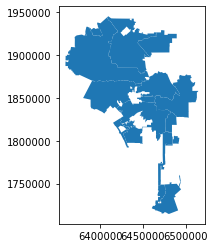

In [9]:
gdfs["congressional_districts"].set_geometry('clipped_geom').plot()